In [206]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
import itertools

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from systemConst import Tunabletransmon,QQ,iniState1Qsys,iniState2Qsys

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0

In [207]:
####### Hamiltonian term generators #######
def ket(Nq, i):
    return qt.basis(Nq, i)

def jj(Nq, lv):
    ket = qt.basis(Nq, lv)
    return ket * ket.dag()

def Delta_q(wqs:list, wd, j):
    return wqs[j] - j * wd

def Hq(Nq, wqs:list):
    Hqs = 0
    for i in range(Nq):
        Hqs = Hqs + wqs[i] * jj(Nq, i)
    return Hqs
    
def Hq_rot(Nq, wqs:list, wd):
    Hqr = 0
    for i in range(Nq):
        D = Delta_q(wqs, wd, i)
        Hqr = Hqr + D * jj(Nq, i)
    return Hqr

def _jj1(Nq, i):
    # for taransmon's destroy operator
    ket_low = qt.basis(Nq, i)
    bra_high = qt.basis(Nq, i+1).dag()
    return ket_low * bra_high

def c(Nq):
    # taransmon's destroy operator
    cc = 0
    for i in range(Nq-1):
        cc = cc + np.sqrt(i + 1) * _jj1(Nq, i)
    return cc

######### N-level paulis #########
def pI_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() + ket(Nq, 1) * ket(Nq, 1).dag()

def pX_N(Nq):
    return ket(Nq, 0) * ket(Nq, 1).dag() + ket(Nq, 1) * ket(Nq, 0).dag()

def pY_N(Nq):
    return 1j*ket(Nq, 0) * ket(Nq, 1).dag() - 1j*ket(Nq, 1) * ket(Nq, 0).dag()

def pZ_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() - ket(Nq, 1) * ket(Nq, 1).dag()

######### N-level Single qubit rotation #########
def RX(theta, Nq, Nf):
    x = pX_N(Nq) * (-1j*theta/2)
    return qt.tensor(x.expm(), qt.qeye(Nf))

def RY(theta, Nq, Nf):
    y = pY_N(Nq) * (-1j*theta/2)
    return qt.tensor(y.expm(), qt.qeye(Nf))

def RZ(theta, Nq, Nf):
    z = pZ_N(Nq) * (-1j*theta/2)
    return qt.tensor(z.expm(), qt.qeye(Nf))

####### Plot utility functions #######
def evals(ini_state, props, e_ops):
    # 与えられた演算子に対する期待値のリストを返す
    
    # 例 
    # input : e_ops = [A, B, C] -> output : [[A-evals], [B-evals], [C-evals]] 
    
    # ini_stateは密度行列で渡す
    # propsは超演算子として渡す
    # e_opsはリストで渡す
    es = []
    for i in range(len(e_ops)):
        ee = []
        for j in range(len(props)):
            r = props[j] * qt.operator_to_vector(ini_state)
            rr = qt.vector_to_operator(r)
            e = qt.expect(e_ops[i], rr).real #qt.expect(ope,state)で期待値
            ee.append(e)
        es.append(ee)
    return es

def bloch(evals):
    # ブロッホ球を描画するだけ
    b = qt.Bloch()
    
    b.add_vectors([evals[0][0], evals[1][0], evals[2][0]])
    b.add_vectors([evals[0][-1], evals[1][-1], evals[2][-1]])
    b.add_points(evals, meth='l')
    b.make_sphere()

    b.show()

    
######## Calc. Propagator ######## ( wrapper of qutip.propagator() )
def simple_prop(H, t_list, c_ops, p_args, mode, steps=10000):
    # 散逸がある場合とない場合でqt.propagatorの返す形式が異なるので、その違いを吸収する。
    # どちらの場合も超演算子形式で返すようにする。
    if mode == 'sch':
        _res = qt.propagator(H, t_list, c_ops=[], args=p_args, parallel=False, options=qt.Options(nsteps=steps))
        res = []
        for i in range(len(_res)):
            sp = qt.to_super(_res[i])
            res.append(sp)
        res = np.array(res)
    elif mode == 'lind':
        res = qt.propagator(H, t_list, c_ops, args=p_args, parallel=False, options=qt.Options(nsteps=steps))
    
    return res

## Fidelity utility
---
Ref : [Direct Fidelity Estimation from Few Pauli Measurements](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.230501)

\begin{align}
    d &= 2^n, n : qubits \\
    \mathcal{U} &: ideal\,channel,\;\; \mathcal{E} : exp.\,channel \\
    \chi_\mathcal{U}(k, k') &= \frac{1}{d}\mathrm{Tr}[W_k \mathcal{U}(W_k')] \\
    X &= \chi_\mathcal{E}(k, k') / \chi_\mathcal{U}(k, k') \\
    Pr(k,k') &= \frac{1}{d^2}\left[ \chi_\mathcal{U}(k, k') \right]^2 \\
    F_e &= {\mathrm{Tr}[\mathcal{U}^\dagger \mathcal{E}]}{d^2} \\
    F_e &= expe.X = \sum_{k, k'}X_{k, k'} Pr(k,k')\\
    F_{avg} &= \frac{d*F_e+1}{d+1}
\end{align}

In [208]:
def paulis_set(Nq, n):
    """
    Return n-qubit system's pauli mat list.

    Parameters
    ----------
    Nq : int
        the max number of transmon energy level

    n : int
        the number of qubit in system

    Returns
    -------
    list of paulis
    """
    pauli = [pI_N(Nq), pX_N(Nq), pY_N(Nq), pZ_N(Nq)]
    p_list = list(itertools.product(pauli, repeat=n))      
    W_set = []
    for k in range(len(p_list)):
        ps = p_list[k]
        w = ps[0]
        for l in range(1, len(ps)):
            w = qt.tensor(w, ps[l])
        W_set.append(w)
    return W_set

#print(len(paulis_set(3,2))) =16

# for One qubit gates
def _tr(Ope, p, q, paulis, Nq, Nf, n):
    """
    Return Chi*d. (see above)

    Parameters
    ----------
    Ope : Qobj
        vectorized whole system propagator

    p : int
        index of pauli
    
    q : int
        index of pauli
        
    paulis : list of Qobj
        list of n-qubit paulis
    
    Nq : int
        max
    
    Nf : int
        max
        
    n : int
        num of qubit
    
    Returns
    -------
    float of chi(p,q)
    """
    Wp = paulis[p]
    Wq = paulis[q]
    Wq_vec = qt.operator_to_vector(qt.tensor(Wq, qt.qeye(Nf)))
    print(Wq_vec)
    b = (Ope * Wq_vec)
    c = qt.vector_to_operator(b).ptrace(0) / Nf
    a = Wp * c
    mat = a.full()
    return abs(mat[0][0] + mat[1][1])

def agf(Ope, target, Nq, Nf, n):
    """
    Return the tuple (average gate fidelity, entanglment fidelity, prb sum for cheack)

    Parameters
    ----------
    Ope : Qobj
        vectorized whole system propagator
        
    target : Qobj
        target gate having same diention as Ope
    
    Nq : int
        max
    
    Nf : int
        max
        
    n : int
        num of qubit
    
    Returns
    -------
    tuple of float ->
    (average gate fidelity, entanglment fidelity, prb sum for cheack)
    """
    d = 2**n
    paulis = paulis_set(Nq, n)
    eX = []
    P = []
    for p in range(len(paulis)):
        for q in range(len(paulis)):
            e = _tr(Ope, p, q, paulis, Nq, Nf, n)/d
            u = _tr(target, p, q, paulis, Nq, Nf, n)/d
            prb = (1/(d**2)) * u**2
            P.append(prb)
            if u != 0:
                eX.append((e/u)*prb)
            else:
                eX.append(0)
    Fe = np.sum(eX)
    Fave = (d * Fe+1)/(d+1)
    return Fave, Fe, np.sum(P)

target = qt.to_super(RX(pi/2, 3, 3))
paulis=paulis_set(3,2)

## Pulse shape
---

In [209]:
def square(Tg, scale=1):
    return np.ones(Tg) * scale

def gaussian(Tg, sigma, nPoints, scale=1, fs=1, PLOT=False):
    shape = np.zeros(nPoints)
    for i in range(nPoints):
        x = i * (1/fs) # 1/fs [ns]
        a = scale * np.exp(- (x - Tg/2)**2 / (2*sigma**2))
        shape[i] = round(a, 15)
    if PLOT:
        plt.figure()
        plt.plot(np.linspace(0, Tg, nPoints), shape, 'o', markersize=2)
        plt.show()
    return shape

def flatTopGaussian(Tg, sigma, edgeLen, scale=1, fs=1, PLOT=False):
    nPoints = Tg
    shape = np.zeros(nPoints)
    for i in range(nPoints):
        x = i * (1/fs) # 1/fs [ns]
        if x < edgeLen:
            a = scale * np.exp(- (x - (edgeLen))**2 / (2*sigma**2))
        elif x > Tg-edgeLen-1:
            a = scale * np.exp(- (x - (Tg-edgeLen-1))**2 / (2*sigma**2))
        else:
            a = scale * 1
        shape[i] = round(a, 15)
    if PLOT:
        plt.figure()
        plt.plot(np.linspace(0, Tg, nPoints), shape)
        plt.show()
    return shape

def sech_pulse(gt, sigma, points=100, scale=1, PLOT=False):
    t = np.linspace(0, gt, points)
    shape = scale / np.cosh(sigma*(t-gt/2))
    if PLOT:
        plt.figure()
        plt.plot(t, shape)
        plt.show()
    return shape

def MW_shaped(t, args):
    shape = args['shape']
    amp = args['mwamp']
    if len(shape) == int(t):
        n = int(t) - 1
    else:
        n = int(t)
    return amp * shape[n]

## Parameters
---

In [210]:
# Q1
Ej1 = 17
Ec1 = 0.27
# Q2
Ej2 = 22
Ec2 = 0.27

###### qubit [GHz] ######
Nq = 3
Q1 = Tunabletransmon(EC=Ec1,EJmax=Ej1,Nq=Nq)
Q2 = Tunabletransmon(EC=Ec2,EJmax=Ej2,Nq=Nq)
wq1s=Q1.enes
wq2s=Q1.enes

wq1=Q1.f01*(2*pi)
wq2=Q2.f01*(2*pi)

J=0.015 #[GHz]
QQ=QQ(Q1,Q2,J)

-0.3044597918959724


## Hamiltonian assembling
---

In [203]:
i = qt.qeye(2)
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()
sp = qt.sigmap()
sm = qt.sigmam()

Iq1 = qt.qeye(Nq)
Iq2 = qt.qeye(Nq)
####### effective N-level pauli #######
px = pX_N(Nq)
py = pY_N(Nq)
pz = pZ_N(Nq)

X1 = qt.tensor(px, Iq2)
Y1 = qt.tensor(py, Iq2)
Z1 = qt.tensor(pz, Iq2)
e_ops = [X1, Y1, Z1]

###### Assembling Lab frame Hamiltonian ######
# 2qubit-labframe
c1 = c(Nq)
C1 = qt.tensor(c1, Iq2)
c2 = c(Nq)
C2 = qt.tensor(Iq1,c2)

Hq1_lab = qt.tensor(Hq_rot(Nq, wq1s, 0), Iq2)
Hq2_lab = qt.tensor(Iq1,Hq_rot(Nq, wq2s, 0))
Hint = QQ.Hint12
Hlab = Hq1_lab + Hq2_lab + Hint

###### Calc. Drive frequency ######
eigenE = Hlab.eigenenergies()
wd = eigenE[1]

#2qubit-rotatingframe
if Nq==2:
    anhs=[0,0]
else: #Nq=3
    anhs=[0,0,Q2.anh]
rot2 = Hq(Nq,anhs)
q2Freqs = qt.qdiags(np.arange(0,Q2.Nq,1),0)
Hq2_t_ind = qt.tensor(Iq1, rot2) #Hq2_rot(constant term)
Hq2_t_dep = qt.tensor(Iq1, q2Freqs) #Hq2_rot(modulation term)
H_rot = [Hq1_lab + Hq2_t_ind + Hint, [Hq2_t_dep, MW_shaped]]

[ 0.          5.76098188  5.79098188 11.24457608 11.24750398 11.55489167
 16.99348586 17.05348586 22.49500796]


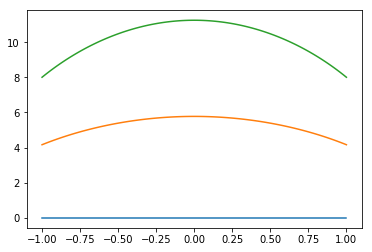

In [204]:
philist,lev0=Q1.calcNthlevelenergy(EC=Ec1,EJmax=Ej1,N=10,level=0)
lev1=Q1.calcNthlevelenergy(EC=Ec1,EJmax=Ej1,N=10,level=1)[1]
lev2=Q1.calcNthlevelenergy(EC=Ec1,EJmax=Ej1,N=10,level=2)[1]
"""
plt.figure()
plt.plot(philist,lev0)
plt.plot(philist,lev1)
plt.plot(philist,lev2)
plt.show()
"""

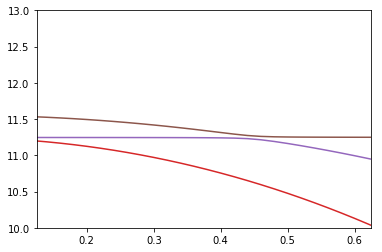

In [205]:
philist=np.linspace(-1,1,101)
levtable=np.zeros((Nq**2,len(philist)))

plt.figure()
for n in range(0,Nq**2):
    for i in range(len(philist)):
        phi=philist[i]
        wq2s_mod = Q2.calcChargeQubitLevels(EC=Ec1,EJmax=Ej1,N=10,Phi=phi)
        Hlab_mod = qt.tensor(Hq_rot(Nq, wq1s, 0), Iq2) + qt.tensor(Iq1,Hq_rot(Nq, wq2s_mod, 0)) + QQ.Hint12
        eigenE_mod = Hlab_mod.eigenenergies()
        levtable[n][i] = eigenE_mod[n]
    plt.plot(philist,levtable[n])
plt.xlim([0.125,0.625])
plt.ylim([10,13])

plt.show()

In [165]:
###### Assembling Rotating frame Hamiltonian ######
q1 = Hq_rot(Nq, wq1s, wd)
Hqs = qt.tensor(q1, Iq2)

# Assembling
H0 = Hqs + Hcav
Hint = int11
Hrot = [H0 + Hint, [Hd1_real, MW_shaped]]

NameError: name 'wqs1' is not defined

In [7]:
###### Gate time ######
mwamp = 0.35
Tg = 30 # [ns]
sigma = 10
edge = sigma*2

squ = square(Tg, scale=1)
gau = gaussian(Tg, sigma, Tg, scale=1, fs=1, PLOT=True)
ftg =  flatTopGaussian(Tg, sigma, edge, scale=1)
sech = sech_pulse(Tg, 0.2, points=Tg, scale=1)

args = {'mwamp':mwamp, 'shape':gau}
t_step = Tg
t_list = np.linspace(0, Tg, 30)

<IPython.core.display.Javascript object>

In [8]:
res = simple_prop(Hrot, t_list, [], args, 'sch')

In [9]:
ini_state = ini_states(Nq, Nfock, '|g>', 'rho')
bloch(evals(ini_state, res, e_ops))
print(evals(ini_state, res, e_ops))

<IPython.core.display.Javascript object>

[[0.0, -0.00814857965259761, -0.029860143271466764, -0.05693336623972477, -0.07857943761216588, -0.08686068622709356, -0.08071187089873676, -0.06632167529592584, -0.05375881156733211, -0.051708398928836274, -0.06295682153138764, -0.08276613743015997, -0.10121979599550392, -0.1086997897847541, -0.10129310454670389, -0.08253583745241165, -0.06064615005120398, -0.043684546971293044, -0.03567282734465578, -0.03515816242354418, -0.03655376038734106, -0.03383585484713489, -0.02456050198804795, -0.011132866765682372, 0.0016865225180603953, 0.010447081338974287, 0.014562092177514249, 0.015438280583064979, 0.01513793964105424, 0.015493537102700223], [0.0, -0.001999393937565125, -0.01512437024090043, -0.04650118015593366, -0.09600026820705025, -0.15633468511281823, -0.2168804486636178, -0.2691531352864708, -0.3109102286438687, -0.3468249431862033, -0.3856386146879416, -0.4352523310421951, -0.49813671239024176, -0.5696959943807538, -0.6408024759278035, -0.7027643874659142, -0.751257448989095, -0.

## Fidelity

In [23]:
target = qt.to_super(RX(pi/2, Nq, Nfock))
Fave, Fe, prb = agf(target, target, Nq, Nfock, 1)
print('Fave = '+'{:.2f}'.format(Fave*100))

Fave = 100.00
